In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

#from sklearn import metrics

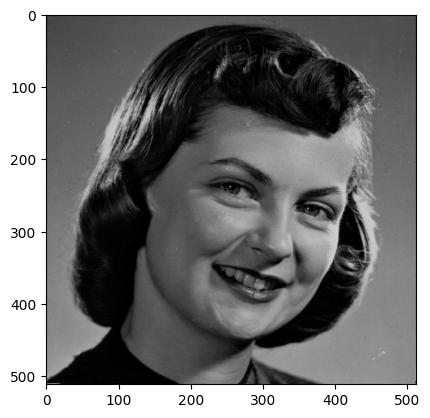

In [3]:
img = cv2.imread("GirlFace.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Part 1

## 1.1 Histogram
- Download the Girl Face image 
- Plot a histogram of the grey levels it contains. (Try plotting a histogram of another grey scale image and comparing the difference)

##### 5 points

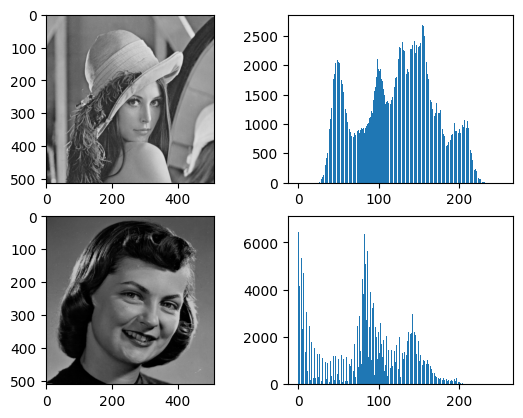

In [4]:
def createHistogram(image):
    values = np.zeros(256)
    n = image.shape[0]
    m = image.shape[1]
    for i in range(0,n):
        for j in range(0,m):
            values[image[i,j]] += 1
    return values

city = cv2.imread("Lena.bmp")
imgVals = createHistogram(city)

#image 1
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(city, cv2.COLOR_BGR2RGB))
#plot 1
plt.subplot (2, 2, 2)
plt.bar(range(len(imgVals)), imgVals)
#image 2
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#plot 2
plt.subplot(2, 2, 4)
imgVals = createHistogram(img)
plt.bar(range(len(imgVals)), imgVals)
plt.show()

## 1.2 Threshold 
- Write a short program to threshold the image and try to identify a good threshold by trial and
error. 
- Create a ground truth segmentation. 
        Ground truths are “true and accurate” segmentations that are typically made by one or more human experts.

#### 15 points

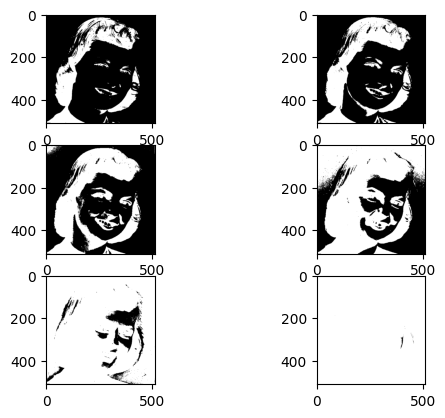

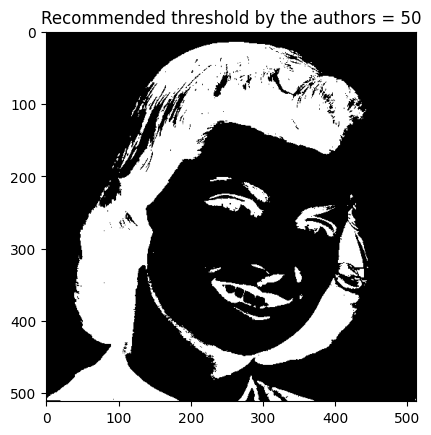

In [10]:
def ApplyThreshold(img, t):
    a = np.average(np.reshape(img, (img.shape[0]*img.shape[1], img.shape[2])), axis = 1)
    return np.reshape(a > t, (img.shape[0], img.shape[1], 1))
trialAndError = [25, 50, 75, 100, 150, 200]
f, s = plt.subplots((len(trialAndError) + 1)//2, 2)
for i, t in enumerate(trialAndError):
    s[i // 2, i % 2].imshow(ApplyThreshold(img, t), cmap = 'binary')
plt.show()
recommendedT = 50
plt.imshow(ApplyThreshold(img, recommendedT), cmap = 'binary')
plt.title("Recommended threshold by the authors = " + str(recommendedT))
plt.show()

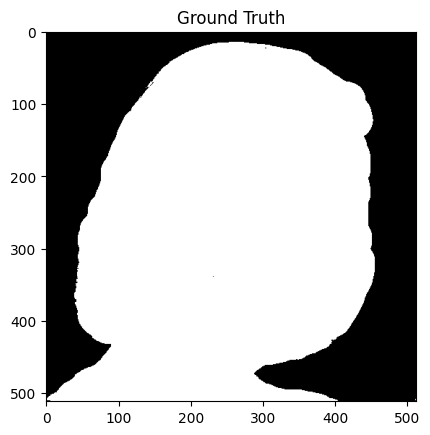

In [6]:
groundTruth = cv2.imread("GirlFaceGroundTruth.png")
groundTruthImage = ApplyThreshold(groundTruth, 50)
plt.imshow(groundTruthImage, cmap = 'binary')
plt.title("Ground Truth")
plt.show()

## 1.3 ROC Curve
- Use your ground truth segmentation to plot an ROC curve for your thresholding algorithm. 
    
    `What threshold does the ROC curve suggest?`
        Note: You may have to implement an algorithm to find the point closest to a desired Operating Point. 
    `How does it compare to your trial and error estimate?`

#### 30 points

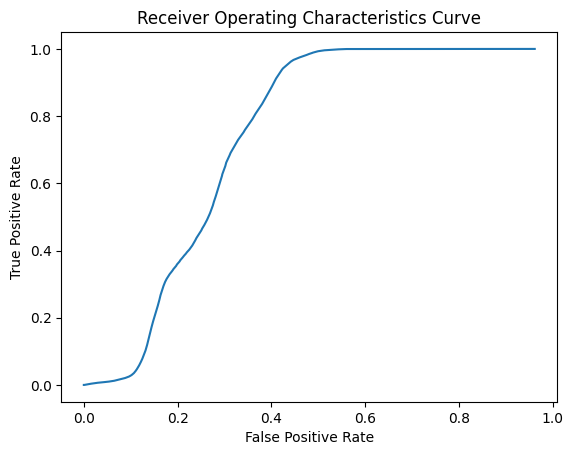

In [18]:
# True positive rate
#    The higher TPR, the fewer positive data points we will miss.
def TPR(groundTruth, estimation): 
    tp = sum(sum(np.logical_and(groundTruthImage, estimation)))
    differ = np.logical_xor(estimation, groundTruthImage)
    fn = sum(sum(np.logical_and(differ, groundTruthImage)))
    if tp + fn == 0: return 0
    return tp/(tp + fn)
# False positive rate
#    The higher FPR, the more negative data points will be missclassified
def FPR(groundTruth, estimation): 
    tn = sum(sum(np.logical_not(np.logical_or(groundTruthImage, estimation))))
    differ = np.logical_xor(estimation, groundTruthImage)
    fp = sum(sum(np.logical_and(differ, estimation)))
    if fp + tn == 0: return 0
    return fp/(fp + tn)
thresholds = np.arange(0, 255, 1)
TPRs, FPRs = np.zeros(len(thresholds)), np.zeros(len(thresholds))
point, chosenT = [1, 1], 0 #To keep track of the best operating point
for i, t in enumerate(thresholds):
    estimation = ApplyThreshold(img, t)
    #tn, fp, fn, tp = metrics.confusion_matrix(groundTruthImage.flatten(), estimation.flatten()).ravel()
    #print("---------", i, tp/(tp + fn), fp/(fp + tn))
    TPRs[i] = TPR(groundTruthImage, estimation)
    FPRs[i] = FPR(groundTruthImage, estimation)
    if abs(TPRs[i] - FPRs[i]) > abs(point[0] - point[1]):
        point, chosenT = (TPRs[i], FPRs[i]), t
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristics Curve")
plt.plot(FPRs, TPRs)

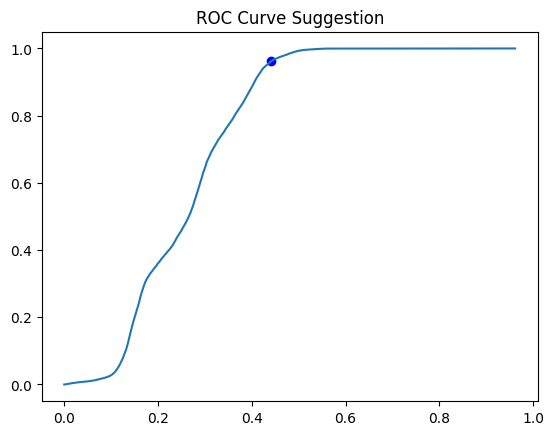

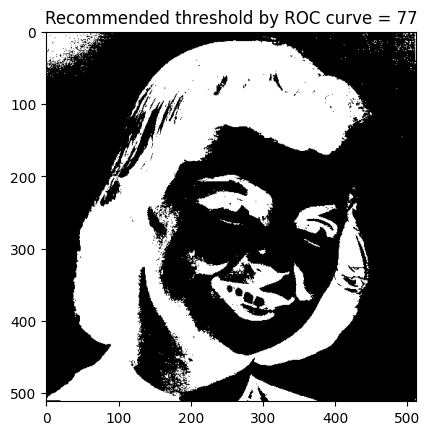

Operating point: TPR = [0.96227285] FPR = [0.44165004]
Authors' point: TPR = [1.] FPR = [0.56738655]


In [26]:
plt.plot(point[1], point[0], 'bo')
plt.plot(FPRs, TPRs)
plt.title("ROC Curve Suggestion")
plt.show()
plt.imshow(ApplyThreshold(img, chosenT), cmap = 'binary')
plt.title("Recommended threshold by ROC curve = " + str(chosenT))
plt.show()

print("Operating point: TPR =", TPR(groundTruthImage, ApplyThreshold(img, 77)), "FPR =", FPR(groundTruthImage, ApplyThreshold(img, 77)))
print("Authors' point: TPR =", TPR(groundTruthImage, ApplyThreshold(img, 50)), "FPR =", FPR(groundTruthImage, ApplyThreshold(img, 50)))

# Part 2

## 2.1 Region growing algorithm 
- Implement a region growing algorithm 
- Compare its performance at segmenting the face in the image above with the performance of the thresholding algorithm.
- Show the seeds you chose.

#### 25 points

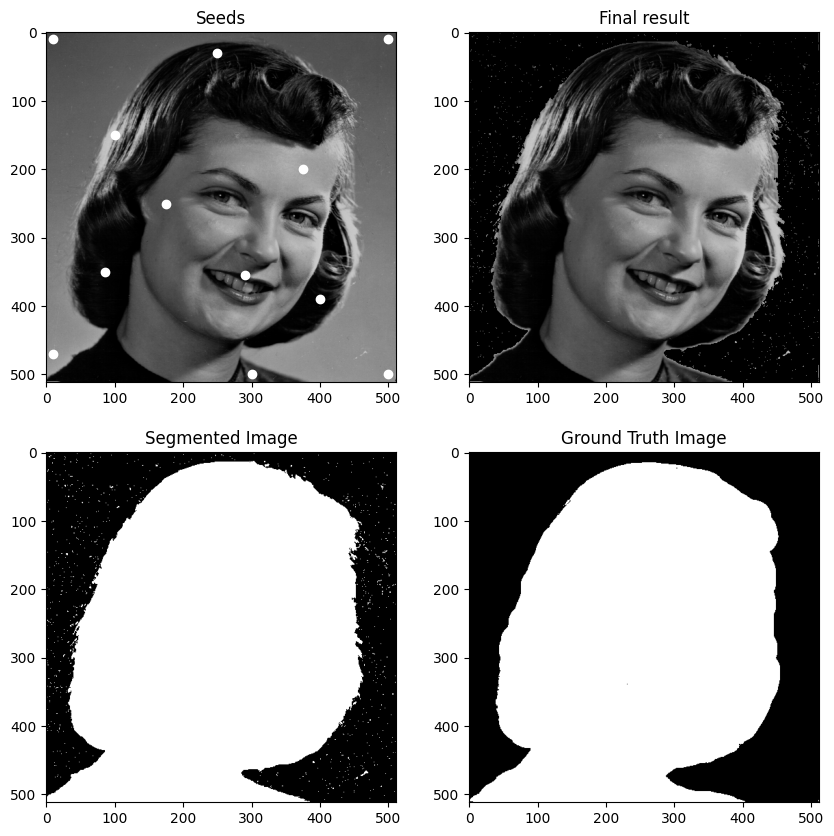

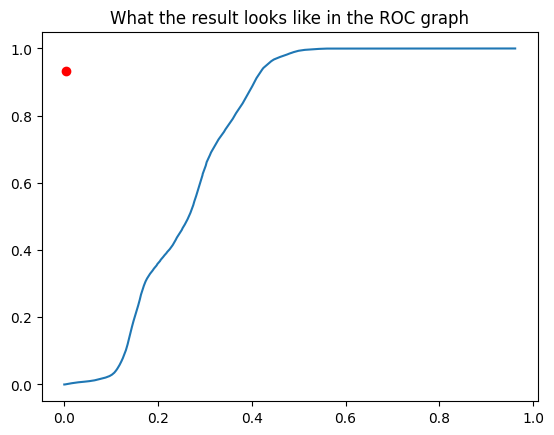

In [22]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# Defining seeds
seedX = [250, 100, 85, 400, 300, 175, 375, 290, 10, 500, 10, 500]
seedY = [30, 150, 350, 390, 500, 250, 200, 355, 10, 10, 470, 500]
girl = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
plt.plot(seedX, seedY, 'wo')
plt.title("Seeds")


def RegionGrowing(image, seeds, tolerance = 10):
    dirs = [[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 1], [1, -1], [1, 0], [1, 1]]
    def isWithinImage(i, j):
        return i >= 0 and j >= 0 and i < image.shape[0] and j < image.shape[1]
    def colorDiff(a, b):
        return abs(int(a[0]) - int(b[0])) + abs(int(a[1]) - int(b[1])) + abs(int(a[2]) - int(b[2]))
    v = np.full((image.shape[0], image.shape[1]), -1)
    seeds = list(seeds)
    while len(seeds):
        pixel = seeds.pop()
        for d in dirs:
            n = [pixel[0] + d[0], pixel[1] + d[1]]
            if isWithinImage(n[0], n[1]) and v[n[0], n[1]] == -1:
                if colorDiff(image[pixel[0], pixel[1]], image[n[0], n[1]]) <= tolerance:
                    seeds.append([n[0], n[1], pixel[2]])
                    v[n[0], n[1]] = pixel[2]
    return v
                
visited = RegionGrowing(img, np.stack((seedX, seedY, girl), axis = 1))
nImg, segmented = img.copy(), np.zeros((img.shape[0], img.shape[1], 1))
for i, row in enumerate(visited):
    for j, isGirl in enumerate(row):
        if not isGirl:
            nImg[i, j] = (0, 0, 0)
            segmented[i, j] = 1
        else: 
            segmented[i, j] = 0
plt.subplot(2, 2, 2)
plt.imshow(nImg)
plt.title("Final result")
plt.subplot(2, 2, 3)
plt.imshow(segmented, cmap = "binary")
plt.title("Segmented Image")
plt.subplot(2, 2, 4)
plt.imshow(groundTruthImage, cmap = "binary")
plt.title("Ground Truth Image")
plt.show()

plt.plot(FPRs, TPRs)
plt.plot(FPR(groundTruthImage, segmented), TPR(groundTruthImage, segmented), 'ro')
plt.title("What the result looks like in the ROC graph")
plt.show()

## 2.2 Mean-shift algorithm
- Implement the mean-shift algorithm.
- Show the results that you achieve for different values of the 'radius' parameter.

#### 25 points

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=4 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Number of segments:  50
Radius:  4


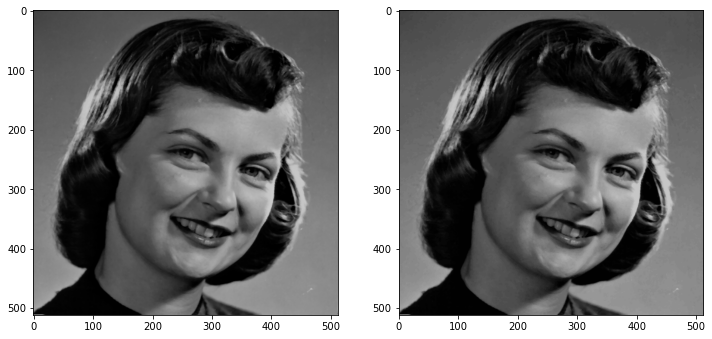

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=11 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Number of segments:  11
Radius:  11


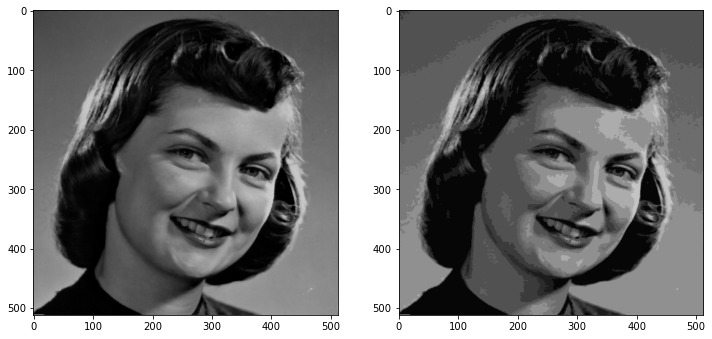

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=50 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Number of segments:  3
Radius:  50


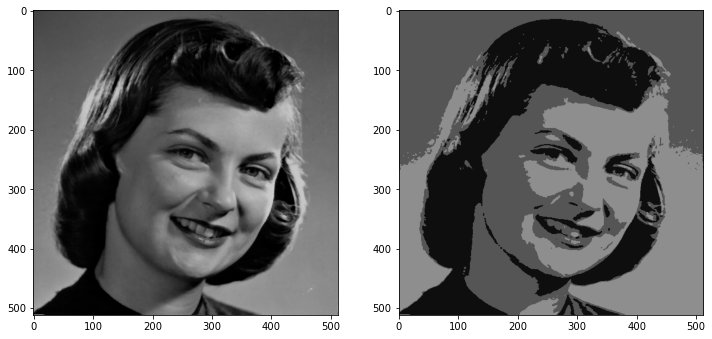

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=100 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Number of segments:  1
Radius:  100


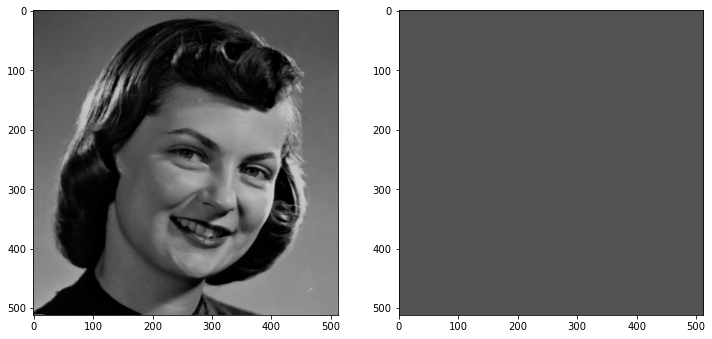

In [28]:
import numpy as np
import cv2 as cv
from sklearn.cluster import MeanShift, estimate_bandwidth

def mean_shift(img, radius):
    # filter to reduce noise
    '''medianBlur():
            takes the median of all the pixels under the kernel area and 
            the central element is replaced with this median value.
    '''
    img = cv.medianBlur(img, 3) 

    # flatten the image
    ''' reshape image (flat) '''
    flat_image = img.reshape((-1,3))

    # meanshift
    ''' 
        -set 4 different radius in order to see how it influences the result.
        -we don't need too many iterations to start seeing results.
        -if we set "bin_seeding" to True, a very few seeds will be initialized. 
         Thus we can speed up the algorithm
    '''
    ms = MeanShift(radius, max_iter=800, bin_seeding=True)
    ms.fit(flat_image)
    labeled=ms.labels_

    # get number of segments
    segments = np.unique(labeled)
    print('Number of segments: ', segments.shape[0])

    # get the average color of each segment
    total = np.zeros((segments.shape[0], 3), dtype=float)
    count = np.zeros(total.shape, dtype=float)
    ''' initialize two matrix of 3xsegment's size, for each channel''' 
    for i, label in enumerate(labeled):
        total[label] = total[label] + flat_image[i]
        count[label] += 1
    avg = total/count
    avg = np.uint8(avg)

    # cast the labeled image into the corresponding average color
    '''return it to its original shape'''
    res = avg[labeled]
    result = res.reshape((img.shape))
    
    print("Radius: ", radius)
    # show the result
    '''show the comparison between images'''
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.show()
    
mean_shift(img, 4) # we can't even see the segmentation.
mean_shift(img, 11) # for me, this is the perfect balance between the four segmented images, we can perfectly appreciate the pixels segmentation.
mean_shift(img, 50) # we start loosing the image information.
mean_shift(img, 100) # we totally lost the image information.


'''
    reference: 
        https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html
    source code: 
        https://github.com/scikit-learn/scikit-learn/blob/36958fb24/sklearn/cluster/_mean_shift.py#L255
'''

# Detailed report
- Point out your process, thoughts and outcomes.

### Introduction

### Process

#### 1.1 Histogram
    
##### Sara's thoughts
> Based on the Girls Face's histogram, we can see how the black and strong greys predominate the image. In the other hand, Lena's image has lighter greys, this can explain why this two image's histograms differ a lot.
##### Luis' thoughts
    
> What I can tell based on the histograms is that the background consists of a lot of pixels and their gray value lies between the hair and face values. That indicates that having a single threshold might not work that well, since trying to capture the background would missclassify either the hair or the face.

#### 1.2 Threshold

As seen in the histogram, finding a threshold by trial and error was not easy task since big and small values have lots of errors and that indicates that the categories are not completely separated from each other, and values in the middle are able to catch the main parts of the girl's face, but it fails to capture the whole head.

##### Sara's thoughts
> This method isn't that good enough to use it as a classifier.
##### Luis' thoughts

> I would not recommend this method to classify the image.
    
#### 1.3 ROC Curve

`What threshold does the ROC curve suggest?`

    A simple algorithm was implemented to find a point on the curve with the biggest difference between True positive rate and False positive rate. That's because the bigger that gap is, the better True pixels are found without missclassifying the False ones. So, the chosen point is pretty self explanatory, since it lies on almost the top of the curve where a lot of True pixels are being well identified without overclassifying everything as True, the point corresponds to the image with a threshold = 77.

`How does it compare to your trial and error estimate?`

    The image chosen by the ROC curve (t = 77) is similar to the authors' (t = 50), and in terms of results:
        The operating point has a TPR value of 0.96227285 and an FPR value of 0.44165004.
        The authors' point has a TPR value of 1 and an FPR value of 0.56738655.
    That means that the authors' point was never wrong at choosing True values, on the other hand, the operating point has a smaller FPR, and that indicates that it misclassified less False pixels, based on that, both results are good enough and have their own Pros and Cons.
 
##### Sara's thoughts
> This ROC Curve can makes us see how the algorithms actually work. Because maybe at first sight we think a pixel is correctly classified, but since the pixels are too small, we can't actually decide between it is wrongly or correctly classified. That's why this ROC Curve is so useful.
   
##### Luis' thoughts

> Even though the chosen thresholds are similar, what that difference looks like is the definition of the girl's face, because it's possible to see that our choice tries to keep the human vibe and the ROC curve found the threshold that catches as many True values as possible.
    
#### 2.1 Region growing algorithm

The region growing algorithm starts with some seeds (in this case chosen by the authors) and based on the similarity between pixels belonging to a specific region and their neighbors the labels spread throughout the image, segmentating it on the process.

The idea followed to set the seeds where they are was making sure to seed the parts that are different from the others even though they belong to the same region.
 
##### Sara's thoughts
>This method highly exceeded my expectations. It got really good results (compared to previous methods). It was able to identify the girl with a small range of error.
   
##### Luis' thoughts

> I was impressed by the result, compared to the threshold method, region growing is a game changer, it identified the girl almost flawlessly.
    
#### 2.2 Mean-shift algorithm

This algorithm is a centroid-based clustering approach to classify images and aims to discover blobs among the pixels.
This is a heavyweight algorithm and even though the understanding is clear, the optimization is out of the scope of this subject and that's why this specific task is supported by the *sklearn* library.

##### Luis' thoughts
> Mean-shift is a complex algorithm, giving a lot of things to say and to think, the real question here is, is all that work worth it? How good is it at classifying the image? I'd say that unlike threshold, this algorithm is tougher to understand and implement. And still, it isn't quite clear if it's actually able to tell whether a pixel belongs to the girl or the background.
 
##### Sara's thoughts    
> We can clearly appreciate how we start losing image information whenever we start growing the clustering radius. I was really impressed about the results, because we needed to find the perfect balance in this radius. We can explain this loss of information understanding how Mean Shift works. As we have a bigger radius, this radius gradually begins to cover the entire image, thus lossing information.
 
### Conclusion

There are several methods to achieve image segmentation, and all of them have lots of pros and cons, sometimes having a simple and ready to use algorithm is the best choice, but also having a more complex and better idea can give better results depending on the image.

Another thing to bring out is that using the tools (i.e. histograms, ROC curves, TPR, FPR and whatnot) is the best way to evaluate a problem saving us time and providing reliable information.